# Определение стоимости автомобилей

__Описание проекта__:   
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.

__Цель проекта__:  
Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.
Критерии, которые важны заказчику:
* качество предсказания;
* время обучения модели;
* время предсказания модели.

__Ход исследования__:  
Шаг 1. Загрузка данных  
Шаг 2. Изучение данных  
Шаг 3. Подготовка выборки для обучения моделей  
Шаг 4. Обучение различных моделей  
Шаг 5. Анализ времени обучения, времени предсказания и качества моделей   
Шаг 6. Выбор лучшей модели и проверка ее качества на тестовой выборке
Вывод  



In [137]:
#!pip install lightgbm
#!pip install catboost
#!pip install scikit-learn==1.1.3

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import warnings
from sklearn.compose import make_column_transformer

# Шаг 1. Загрузка данных

In [139]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv', sep=',')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


__Вывод по шагу 1:__  
На этом шаге мы загрузили данные для последующей работы

# Шаг 2. Изучение данных

In [140]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

# 2.1 Удаление дубликатов

In [141]:
data.drop_duplicates(inplace=True)

## 2.2. Удаление неинформативных признаков

Заметим, что признаки  
* DateCrawled — дата скачивания анкеты из базы,
* RegistrationMonth — месяц регистрации автомобиля,  
* DateCreated — дата создания анкеты,  
* NumberOfPictures — количество фотографий автомобиля,  
* PostalCode — почтовый индекс владельца анкеты (пользователя),  
* LastSeen — дата последней активности пользователя 

не явялются информативными для создания модели
Удалим эти признаки из датасета

In [142]:
data = data.drop(columns=['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'])
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


## 2.3. Обработка пропусков

In [143]:
def check_missing_values(df):
    for column in df.columns:
        missing_values_count = df[column].isnull().sum()
        print(f"Столбец '{column}': {missing_values_count} пропусков")

In [144]:
check_missing_values(data)

Столбец 'Price': 0 пропусков
Столбец 'VehicleType': 37490 пропусков
Столбец 'RegistrationYear': 0 пропусков
Столбец 'Gearbox': 19833 пропусков
Столбец 'Power': 0 пропусков
Столбец 'Model': 19705 пропусков
Столбец 'Kilometer': 0 пропусков
Столбец 'FuelType': 32895 пропусков
Столбец 'Brand': 0 пропусков
Столбец 'Repaired': 71154 пропусков


In [145]:
data['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [146]:
data['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [147]:
data['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [148]:
data['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [149]:
data['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

Мы обнаружили пропуски в 5 столбцах, давайте заполним их данными
Все столбцы с пропусками, кроме Repaired и Gearbox являются категориальными с большим колличеством уникальных значений, давайте вместо каждого пропуска в этих данных поставим категорию 'unknown'
Также поступим и со столбцом Gearbox, ведь тяжело предположить по какой причине пользователь не внес эти данные

Столбец 'Repaired' содержит данные о том, ремонтировалась ли машина. Логично предположить, что отсутствие данных в этом столбце может свидетельствовать об отсутсвии ремонта у машины.
Поэтому заполним пропуски значением no

In [150]:
data['VehicleType'] = data['VehicleType'].fillna('unknown')
data['Model'] = data['Model'].fillna('unknown')
data['FuelType'] = data['FuelType'].fillna('unknown')
data['Gearbox'] = data['Gearbox'].fillna('unknown')
data['Repaired'] = data['Repaired'].fillna('no')

In [151]:
check_missing_values(data)

Столбец 'Price': 0 пропусков
Столбец 'VehicleType': 0 пропусков
Столбец 'RegistrationYear': 0 пропусков
Столбец 'Gearbox': 0 пропусков
Столбец 'Power': 0 пропусков
Столбец 'Model': 0 пропусков
Столбец 'Kilometer': 0 пропусков
Столбец 'FuelType': 0 пропусков
Столбец 'Brand': 0 пропусков
Столбец 'Repaired': 0 пропусков


От пропусков избавились.

## 2.4. Исследовательский анализ

In [152]:
def visualize_dataframe(dataframe):
    for column in dataframe.columns:
        column_type = dataframe[column].dtype

        if column_type == 'object':
            value_counts = dataframe[column].value_counts()
            value_counts.plot.pie(autopct='%1.1f%%', startangle=90)
            plt.title(f'{column} - Круговая диаграмма')
            plt.show()

        elif column_type in ['int64', 'float64'] and column != 'id':
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

            dataframe[column].plot.hist(bins=25, ax=axes[0])
            axes[0].set_title(f'{column} - Гистограмма')
            axes[0].set_xlabel(column)
            axes[0].set_ylabel('Частота')

            sns.boxplot(x=dataframe[column], ax=axes[1])
            axes[1].set_title(f'{column} - Boxplot')
            axes[1].set_xlabel(column)

            plt.show()
            
            print(dataframe[column].describe())

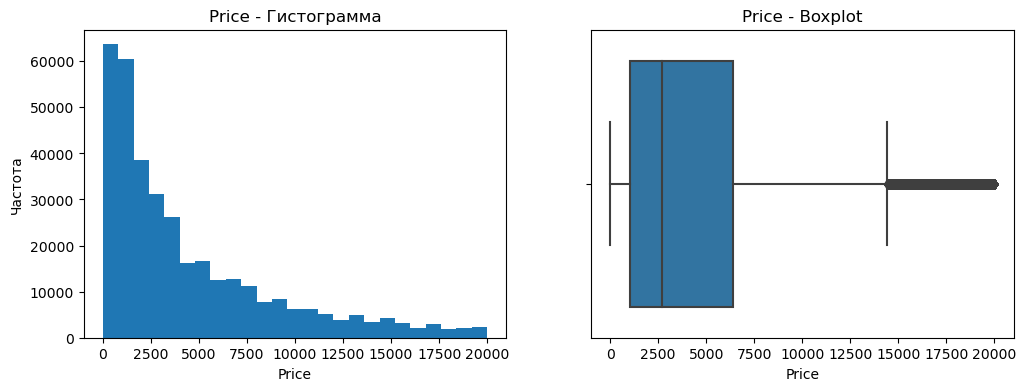

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64


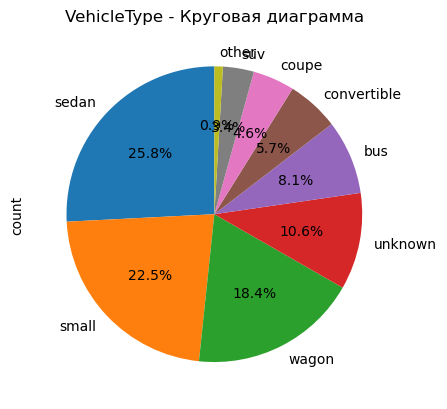

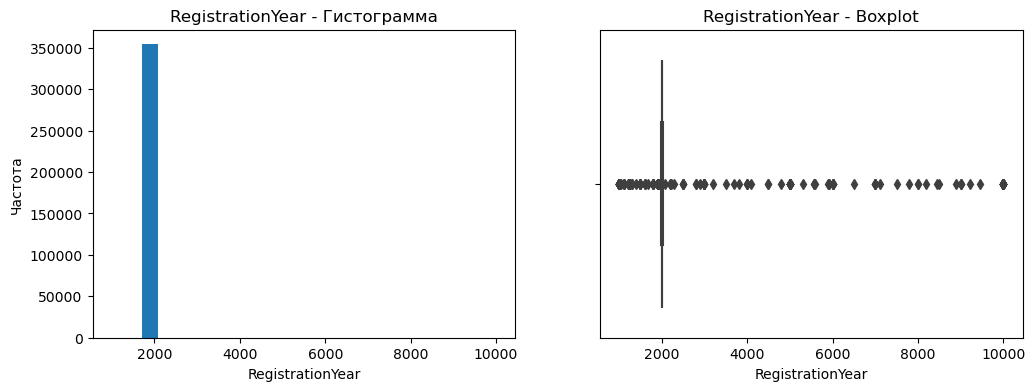

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64


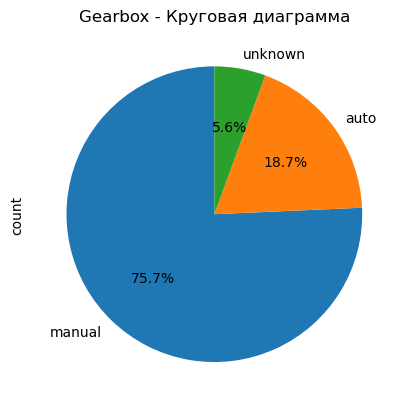

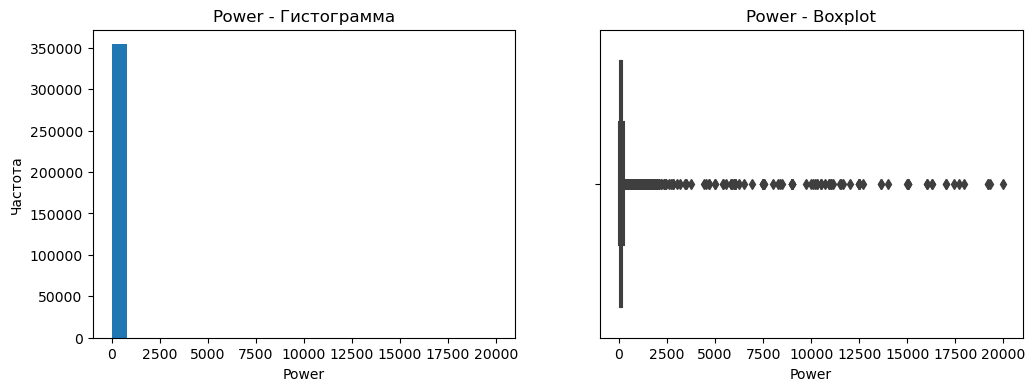

count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64


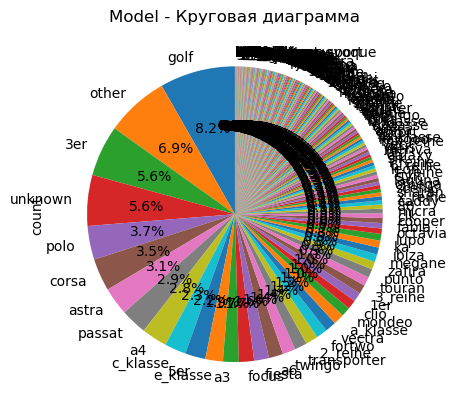

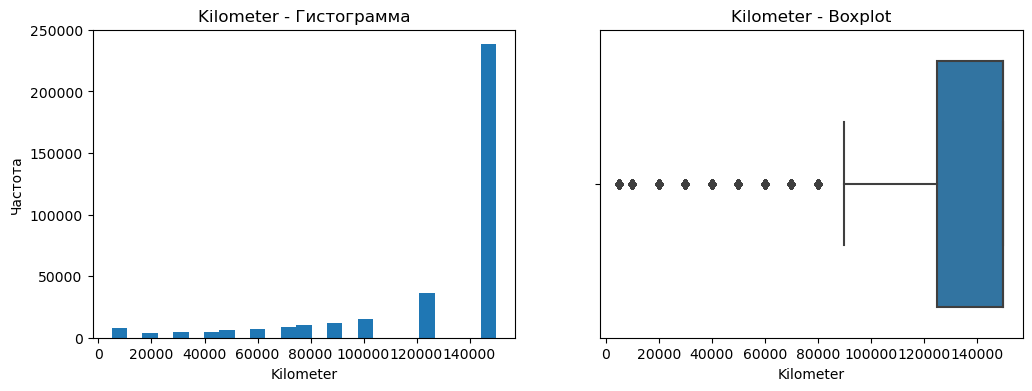

count    354365.000000
mean     128211.363989
std       37905.083858
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64


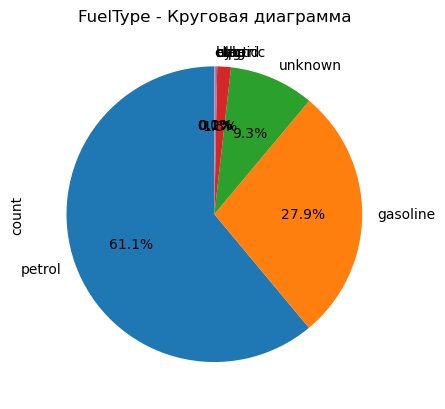

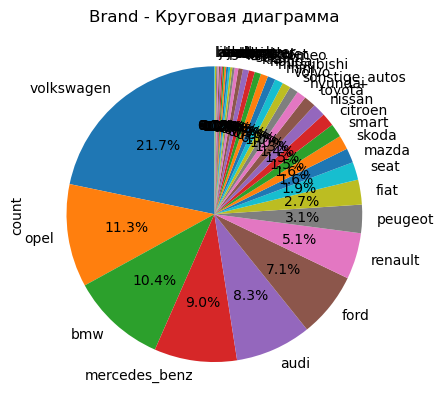

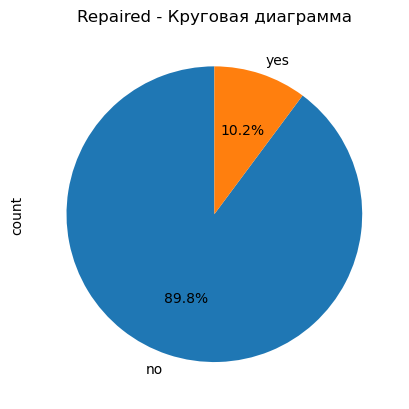

In [153]:
visualize_dataframe(data)

Видим аномалии в данных
* Есть большое колличесвто машин со стоимостью менее 100 евро, что вряд ли соответствует реальности
* Существуют машины с годом выпуска < 1900 или > 2024
* Также давайте ограничим значение количетсва лошадинных сил числами 20 снизу и 1600 сверху (данные взяты с интернета по запросу 'min/max кол-во лc в машине')  
удалим такие данные

In [154]:
data = data[(data['Price'] >= 100)]
data = data[(data['RegistrationYear'] >= 1900) & (data['RegistrationYear'] <= 2016)]
data = data[(data['Power'] >= 20) & (data['Power'] <= 1600)]

In [155]:
data['Price'].describe()

count    295183.000000
mean       4873.472063
std        4611.848824
min         100.000000
25%        1350.000000
50%        3200.000000
75%        6999.000000
max       20000.000000
Name: Price, dtype: float64

In [156]:
data['RegistrationYear'].describe()

count    295183.000000
mean       2002.839601
std           6.512534
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

In [157]:
data['Power'].describe()

count    295183.000000
mean        121.360177
std          59.184902
min          20.000000
25%          76.000000
50%         111.000000
75%         150.000000
max        1600.000000
Name: Power, dtype: float64

In [158]:
data.duplicated().sum()

45106

In [159]:
data.drop_duplicates(inplace=True)

__Вывод по шагу 2:__  
На этом шаге мы удалили неифнормативные признаки, обработали пропуски и явные дубликаты, а также произвели обработку анамалий    

# Шаг 3. Подготовка выборки для обучения моделей

Будем кодировать признаки 'VehicleType','Gearbox', 'Repaired', 'FuelType','Brand' и 'Model' через One-Hot-Encoder
Выделим тренировочную, валидационную и тестовую выборки

In [160]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [161]:
features = data.drop(['Price'], axis=1)
target = data['Price']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=88)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=88)

__Вывод по шагу 3:__  
На этом шаге мы выполнили подготовку для обучения моделей, выделив тренировочную, валидационную и тестовую выборки

# Шаг 4. Обучение различных моделей

__Модель Линейной регрессии__ 

Для модели линейной регрессии будем использовать OneHotEncoder и StandardScaler.

In [162]:
ohe_features_lr = X_train.select_dtypes(include='object').columns.to_list()
print(ohe_features_lr)
num_features = X_train.select_dtypes(exclude='object').columns.to_list()
print(num_features)

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
['RegistrationYear', 'Power', 'Kilometer']


In [163]:
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()
X_val_lr = X_val.copy()

In [164]:
col_transformer_lr = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        ohe_features_lr
    ),
    (
        StandardScaler(),
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

X_train_lr = pd.DataFrame.sparse.from_spmatrix(
    col_transformer_lr.fit_transform(X_train_lr),
    columns=col_transformer_lr.get_feature_names_out()
)

X_train_lr.head()

,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,VehicleType_wagon,Gearbox_manual,Gearbox_unknown,...,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes,RegistrationYear,Power,Kilometer
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.908572,-0.295512,-0.985022
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.159057,0.445641,0.612934
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.590458,-1.135485,-0.052881
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009154,0.330351,0.612934
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.159057,-0.295512,-0.718696


In [165]:
X_test_lr = pd.DataFrame.sparse.from_spmatrix(
    col_transformer_lr.transform(X_test_lr),
    columns=col_transformer_lr.get_feature_names_out()
)

X_test_lr.head()

C:\Users\petre\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,VehicleType_wagon,Gearbox_manual,Gearbox_unknown,...,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes,RegistrationYear,Power,Kilometer
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.159057,-0.361392,0.612934
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.939586,-0.542562,0.612934
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.308960,-0.114341,-1.783999
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.740361,0.775042,0.612934
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.308960,0.445641,-0.985022


In [166]:
X_val_lr = pd.DataFrame.sparse.from_spmatrix(
    col_transformer_lr.transform(X_val_lr),
    columns=col_transformer_lr.get_feature_names_out()
)

X_val_lr.head()

C:\Users\petre\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,VehicleType_wagon,Gearbox_manual,Gearbox_unknown,...,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes,RegistrationYear,Power,Kilometer
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.890264,-0.130811,0.612934
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.308960,0.033890,0.612934
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.590458,-0.789613,0.612934
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1.190070,-0.789613,-0.052881
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.290652,0.280940,0.612934


In [167]:
model_lr = LinearRegression()

param_grid_lr = {
    'fit_intercept': [True, False],'copy_X': [True, False],'n_jobs': [1, -1]
}

gs_lr = GridSearchCV(
    model_lr,
    param_grid=param_grid_lr,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

gs_lr.fit(X_train_lr, y_train)
best_params_lr = gs_lr.best_params_
print(f'best_score: {gs_lr.best_score_ * -1}')

print(f'best_params: {gs_lr.best_params_}')

best_score: 2741.4873345204214
best_params: {'copy_X': True, 'fit_intercept': True, 'n_jobs': 1}


In [168]:
%%time
best_model_lr = LinearRegression(**best_params_lr)
best_model_lr.fit(X_train_lr, y_train)

CPU times: total: 9.14 s
Wall time: 1.62 s


LinearRegression(n_jobs=1)

In [169]:
%%time
val_predictions_lr = best_model_lr.predict(X_val_lr)

CPU times: total: 93.8 ms
Wall time: 29.5 ms


In [170]:
rmse_lr = np.sqrt(mean_squared_error(y_val, val_predictions_lr))
rmse_lr

2714.7444800429744

__Модель LightGBM__

In [171]:
X_train_cat = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()
X_val_lgbm = X_val.copy()
for feature in X_train_cat:
    X_train_lgbm[feature] = X_train_lgbm[feature].astype('category')
for feature in X_train_cat:
    X_val_lgbm[feature] = X_val_lgbm[feature].astype('category')
for feature in X_train_cat:
    X_test_lgbm[feature] = X_test_lgbm[feature].astype('category')    


model_lgbmr = LGBMRegressor() 
parameters = [{'num_leaves':[50, 100, 150, 200, 250], 'learning_rate':[0.1, .25, 0.5, 0.75], 'random_state':[88]}]
grid_cv_lgbmr = GridSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error')
grid_cv_lgbmr.fit(X_train_lgbm, y_train)
best_params_lgbmr = grid_cv_lgbmr.best_params_
best_params_lgbmr


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 647
[LightGBM] [Info] Number of data points in the train set: 112533, number of used features: 9
[LightGBM] [Info] Start training from score 5017.733723
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 112533, number of used features: 9
[LightGBM] [Info] Start training from score 5008.831623
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

{'learning_rate': 0.1, 'num_leaves': 250, 'random_state': 88}

In [172]:
%%time

model_lgbmr = LGBMRegressor(**best_params_lgbmr)
model_lgbmr.fit(X_train_lgbm, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 140667, number of used features: 9
[LightGBM] [Info] Start training from score 5013.707863
CPU times: total: 5.06 s
Wall time: 809 ms


LGBMRegressor(num_leaves=250, random_state=88)

In [173]:
%%time

val_predictions_lgbmr = model_lgbmr.predict(X_val_lgbm)

CPU times: total: 1.12 s
Wall time: 140 ms


In [174]:
rmse_lgbmr = np.sqrt(mean_squared_error(y_val, val_predictions_lgbmr))
rmse_lgbmr

1570.1989154644157

__Модель CatBoostRegressor__

In [175]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
model_cbr = CatBoostRegressor(cat_features=cat_features) 
parameters = [{'n_estimators':[1, 10, 50, 100],'learning_rate':[0.1, 0.25, 0.5, 0.75], 'random_state':[88]}]

grid_cv_cbr = GridSearchCV(model_cbr, parameters, scoring='neg_mean_squared_error')
grid_cv_cbr.fit(X_train, y_train)

best_params_cbr = grid_cv_cbr.best_params_
best_params_cbr


0:	learn: 4384.4590871	total: 37.7ms	remaining: 0us
0:	learn: 4375.7209535	total: 36.2ms	remaining: 0us
0:	learn: 4376.3449902	total: 36.1ms	remaining: 0us
0:	learn: 4387.0849188	total: 35.5ms	remaining: 0us
0:	learn: 4378.1031686	total: 34.7ms	remaining: 0us
0:	learn: 4384.4590871	total: 35.2ms	remaining: 317ms
1:	learn: 4119.6630604	total: 71.4ms	remaining: 286ms
2:	learn: 3889.8020967	total: 115ms	remaining: 269ms
3:	learn: 3672.4072235	total: 152ms	remaining: 228ms
4:	learn: 3491.0857060	total: 191ms	remaining: 191ms
5:	learn: 3322.4064109	total: 236ms	remaining: 157ms
6:	learn: 3173.1935178	total: 279ms	remaining: 120ms
7:	learn: 3047.4445949	total: 317ms	remaining: 79.2ms
8:	learn: 2939.7286544	total: 353ms	remaining: 39.2ms
9:	learn: 2840.2065347	total: 395ms	remaining: 0us
0:	learn: 4375.7209535	total: 44ms	remaining: 396ms
1:	learn: 4111.3803090	total: 90.3ms	remaining: 361ms
2:	learn: 3884.3717607	total: 143ms	remaining: 334ms
3:	learn: 3668.2801056	total: 189ms	remaining: 28

{'learning_rate': 0.5, 'n_estimators': 100, 'random_state': 88}

In [176]:
%%time

model_cbr = CatBoostRegressor(**best_params_cbr, cat_features=cat_features)
model_cbr.fit(X_train, y_train)

0:	learn: 3315.8230990	total: 42.3ms	remaining: 4.18s
1:	learn: 2692.6876692	total: 86.5ms	remaining: 4.24s
2:	learn: 2354.2782959	total: 132ms	remaining: 4.25s
3:	learn: 2189.7391619	total: 180ms	remaining: 4.32s
4:	learn: 2083.4295563	total: 228ms	remaining: 4.33s
5:	learn: 2028.5314744	total: 277ms	remaining: 4.34s
6:	learn: 1996.5623548	total: 324ms	remaining: 4.3s
7:	learn: 1972.3848641	total: 367ms	remaining: 4.21s
8:	learn: 1945.1671829	total: 413ms	remaining: 4.17s
9:	learn: 1933.3658854	total: 460ms	remaining: 4.14s
10:	learn: 1914.1533178	total: 506ms	remaining: 4.09s
11:	learn: 1899.2866215	total: 552ms	remaining: 4.05s
12:	learn: 1888.2433028	total: 596ms	remaining: 3.99s
13:	learn: 1876.4176680	total: 641ms	remaining: 3.94s
14:	learn: 1865.9548110	total: 689ms	remaining: 3.9s
15:	learn: 1857.9196533	total: 742ms	remaining: 3.9s
16:	learn: 1848.7212665	total: 797ms	remaining: 3.89s
17:	learn: 1841.1618120	total: 865ms	remaining: 3.94s
18:	learn: 1835.6746771	total: 922ms	re

In [177]:
%%time

val_predictions_cbr = model_cbr.predict(X_val)

CPU times: total: 31.2 ms
Wall time: 101 ms


In [178]:
rmse_cbr = np.sqrt(mean_squared_error(y_val, val_predictions_cbr))
rmse_cbr

1682.7754031431475

__Вывод по шагу 4:__  
На этом шаге мы создали три модели ('Linear Regression', 'LightGBM', 'CatBoostRegressor'), для каждой из которых определили прараметры, важные для заказчика

# Шаг 5. Анализ времени обучения, времени предсказания и качества моделей.

Составим свобдную таблицу с временем обучения, временем предсказания и качеством всех трех, подобранных нами моделей

In [180]:
results = pd.DataFrame({'Модель': ['Linear Regression', 'LightGBM', 'CatBoostRegressor'],
                        'Время обучения': [1.62 , 0.809, 5.21],
                        'Время предсказания': [0.03, 0.14, 0.101],
                        'Качество (RMSE)': [2714.7444800429744, 1570.1989154644157, 1682.7754031431475]})

results

,Модель,Время обучения,Время предсказания,Качество (RMSE)
0,Linear Regression,1.620,0.030,2714.744480
1,LightGBM,0.809,0.140,1570.198915
2,CatBoostRegressor,5.210,0.101,1682.775403


__Вывод на шагу 5__  
На этом шаге мы составили свободную таблицу параметров, важных заказчику, для трех моделей созданных в предыдущем шаге

# Шаг 6.Выбор лучшей модели и проверка ее качества на тестовой выборке

In [181]:
results

,Модель,Время обучения,Время предсказания,Качество (RMSE)
0,Linear Regression,1.620,0.030,2714.744480
1,LightGBM,0.809,0.140,1570.198915
2,CatBoostRegressor,5.210,0.101,1682.775403


Можем заметить, что модель Linear Regression не проходит порог качества, указанный в задании (RMSE < 2500), поэтому данная модель априори быть лучшей не может. Остается сделать выбор между LightGBM и CatBoostRegressor, в задании не указано какие критерии для заказчика более важные из приведенных, скорее всего в таком случае стоит уточник у заказчика, но если такой возможности нет, решение необходимо принять самостоятельно.   
Можем замеить, что модель LightGBM превосходит CatBoostRegressor по двум параметрам из 3, так как в данной задаче мы являемся ЛПР, давайте выберем модель LightGBM как лучшую.

Теперь оценим качество выбранной модели на тестовой выборке

In [183]:
final_predictions = model_lgbmr.predict(X_test_lgbm)
rmse_final = np.sqrt(mean_squared_error(y_test, final_predictions))
rmse_final

1586.3092154036653

RMSE на тестовой выборке оказалось равным 1586.3092154036653, что явялется отличным результатом

__Вывод по шагу 6__
На этом шаге мы выбрали лучшую модель, которой оказалась LightGBM и подсчитали RMSE для этой модели на тестовой выборке, модель показала отличные результаты

# Вывод

В этом проекте мы получили данные о технических характеристиках, комплектации и ценах автомобилей. После изучения данных и предобработки мы пстроили три модели для предсказания цены (Linear Regression, LightGBM и CatBoostRegressor) и для каждой из них подсчитали критерии выжные для заказчика. По совокупности критериев лучшей моделью стала LightGBM. 